# Symbolic Music Generation #

Se si sta eseguendo su **Google Colab** mettere a *True* la variabile *colab*.

Se si sta eseguendo offline e si vuole utilizzare la GPU per il training mettere a *True* la variabile *use_gpu*.
(Se non è necessario fare training si può anche mettere a *False*)

**ATTENZIONE** per usare la gpu offline sono state usate le seguenti dipendenze:
* python v3.7
* tensorflow v2.1.0
* CUDA Toolkit 10.1
* cuDNN v7.6

Insieme a GPU: *NVDIA GeForce RTX 2060 6GB*

Per utilizzare le funzionalità di **music21** offline bisogna prima installarlo tramite anaconda o il modulo *pip* di python.
Inoltre per visualizzare gli spartiti è necessario installare un visualizzatore di spartiti come **MuseScore**, poi riportare i percorsi corretti nella cella di setup di **music21**

In [1]:
colab = False
use_gpu = True

In [2]:
if colab:
    from google.colab import drive
    drive.mount('/content/drive', force_remount=True) # NON MODIFICARE

**ESEGUIRE LA SEGUENTE CELLA SOLO SU COLAB**:
Codice per installare music21 su Google colab e farlo funzionare

In [ ]:
!pip install --upgrade music21
!add-apt-repository ppa:mscore-ubuntu/mscore-stable -y
!apt-get update
!apt-get install musescore
!apt-get install xvfb
!sh -e /etc/init.d/x11-common start
!start-stop-daemon --start --pidfile /var/run/xvfb.pid --make-pidfile --background --exec /usr/bin/Xvfb -- :99 -screen 0 1024x768x24 -ac +extension GLX +render -noreset

L'esecuzione della seguente cella è opzionale serve a far funzionare la parte di visualizzazione e ascolto dei brani

In [3]:
import music21 as m21
us = m21.environment.UserSettings()
if colab:
    us['musescoreDirectPNGPath'] = '/usr/bin/mscore'    # NON MODIFICARE
    us['musicxmlPath'] = '/usr/bin/mscore'              # NON MODIFICARE
    us['directoryScratch'] = '/tmp'                     # NON MODIFICARE
else:
    us['musescoreDirectPNGPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe'  # MODIFICARE con i propri dati
    us['directoryScratch'] = 'C:/Users/Mario/AppData/Local/Temp'                      # MODIFICARE con i propri dati
    us['musicxmlPath'] = 'C:/Program Files/MuseScore 3/bin/MuseScore3.exe'            # MODIFICARE con i propri dati

In [4]:
import tensorflow as tf
from sklearn.decomposition import PCA
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

In [5]:
from os import listdir, putenv
from os.path import isfile, join
import os
import time
import pickle
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

In [6]:
if colab:
    # MODIFICARE con il percorso su Google Drive dove si è messa la cartella del progetto
    # la parte /content/drive/MyDrive è costante, la parte successiva dipende da dove si è messo il progetto nel proprio drive
    base_path = '/content/drive/MyDrive/MusicNN'
else:
    base_path = ''   # NON MODIFICARE

In [7]:
if not colab and use_gpu:
    gpus = tf.config.experimental.list_physical_devices('GPU')
    if gpus:
        try:
            tf.config.experimental.set_visible_devices(gpus[0], 'GPU')
            tf.config.experimental.set_memory_growth(gpus[0], True)  # RIGA Fondamentale altrimenti crasha sulle RNN
            logical_gpus = tf.config.experimental.list_logical_devices('GPU')
            print(len(gpus), "Physical GPUs,", len(logical_gpus), "Logical GPU")
        except RuntimeError as e:
            print(e)

1 Physical GPUs, 1 Logical GPU


-------------------------------------------------------------------------------

### Load Data
Di seguito è implementata la pipeline per generare il dataset di training, di validation e di test

In [8]:
data_obj = join(base_path, 'BachChorales/jsb-chorales-quarter.pkl')

In [9]:
with open(data_obj, 'rb') as f:
    data = pickle.load(f,encoding='latin1')

In [10]:
len(data['train'])

229

In [11]:
train_data = data['train']
valid_data = data['valid']
test_data = data['test']
Ntrain = len(train_data)
Nvalid = len(valid_data)
Ntest = len(test_data)
print('training pieces:', Ntrain, '', Ntrain*100//(Ntrain+Nvalid+Ntest),'%')
print('validation pieces:', Nvalid, '', Nvalid*100//(Ntrain+Nvalid+Ntest),'%')
print('test pieces:', Ntest, '', Ntest*100//(Ntrain+Nvalid+Ntest),'%')

training pieces: 229  59 %
validation pieces: 76  19 %
test pieces: 77  20 %


In [12]:
def split_voices(data):
    flats = [[],[],[],[]] # 4 voci separate
    for seq in data: # per ogni sequenza seq
        # Inserisco una nuova sequenza vuota per ogni voce
        for i in range(len(flats)):
            flats[i].append([])

        # Per ogni timestep nella sequenza seq
        for col in seq:

            # Valuto quante voci ci sono in questo timestep
            for i in range(len(col)):
                if i < 4:
                    if col[i] != 0:
                        flats[i][-1].append(col[i]) # inserisco questa nota nella corrispondente sequenza
                else:
                    print('faulty column')

        tot = flats[0]+flats[1]+flats[2]+flats[3]
        # Pulisco perché può accadere che alcune sequenze siano vuote poiché una certa
        # voce non aveva note in un pezzo
        clean = []
        for seq in tot:
            if len(seq) != 0:
                clean.append(seq)
    return clean

In [13]:
def flatten_voices(data):
    flats = []
    for seq in data: # per ogni pezzo di Bach
        # Inserisco una nuova sequenza vuota
        flats.append([])

        # Per ogni timestep nella sequenza seq
        for col in seq:
            for i in range(len(col)):
                if i < 4:
                    if col[i] != 0:
                        flats[-1].append(col[i])
                else:
                    print('faulty column')

    return flats

In [14]:
tmp1 = split_voices(train_data)
#tmp1 = flatten_voices(train_data)
print('N:', len(tmp1), 'L_0', len(tmp1[0]))

N: 916 L_0 129


Una trasformazione per aumentare i dati senza perdere la struttura del pezzo è la trasposizione ddelle note di un numero k di semitoni

In [15]:
def semitone_transpose(data, semitones):
    """
    Data è atteso in token MIDI
    semitones è una lista di semitoni per cui trasporre
    """
    ndata = []
    for seq in data:
        for ss in semitones:
            ndata.append([])
            for token in seq:
                assert token+ss <= 128, "cannot transpose out of range {}".format(ss)
                assert token+ss >= 1, "cannot transpose out of range {}".format(ss)
                ndata[-1].append(token+ss)
    return ndata+data

In [16]:
tmp12 = semitone_transpose(tmp1, [i for i in range(1,20)]+[-i for i in range(1,20)])
len(tmp12)

35724

In [17]:
def map_tokens(data, min_token=None, max_token=None):
    if min_token is None or max_token is None:
        min_token = 10000
        max_token = 0
        for seq in data:
            for token in seq:
                if token>max_token:
                    max_token = token
                if token < min_token:
                    min_token = token
  
    new_data = []
    for i in range(len(data)):
        new_data.append([])
        for j in range(len(data[i])):
            if data[i][j] < min_token or data[i][j] > max_token:
                continue
            new_data[i].append(data[i][j]-min_token+1) # 0 is a padding value
  
    return new_data, min_token, max_token

In [18]:
tmp2, min_token, max_token = map_tokens(tmp12)
vocab_size = max_token-min_token+1
print('N =',len(tmp2), 'min token', min_token, 'max token', max_token, 'vocab size', vocab_size)

N = 35724 min token 24 max token 115 vocab size 92


Nella terza trasformazione porto tutte le sequenze alla lunghezza massima $L_{max}$ usando un padding post di zeri.

In [19]:
def make_matrix(flatten):
    # Trovo la lunghezza massima
    maxlen = 0
    for seq in flatten:
        if len(seq) > maxlen:
            maxlen = len(seq)

    # Per ogni sequenza in flatten
    for i,seq in enumerate(flatten):
        if len(seq) < maxlen: # Se è più corta
            for j in range(maxlen-len(seq)): # riempio di zeri a dx
                flatten[i].append(0)
    return flatten, maxlen

In [20]:
tmp3, Lmax = make_matrix(tmp2)
print('N:', len(tmp3), 'Lmax:', len(tmp3[0]))

N: 35724 Lmax: 129


Adesso si calcola la nuova dimensione del dataset che si ottiene facendo scorrere su ogni sequenza una finestra lunga $ L $ con stride $ s $:
$$ N = N_0\lfloor (L_{max}-L+1)\frac{1}{s} \rfloor $$

**Punto di Configurazione del dataset**

In [21]:
N0 = len(tmp3)
L = 20
s = 7
print('N =', N0*((Lmax-L)//s))

N = 535860


In [22]:
def windowing(data, L, s):
    assert L>0 and s>0, "Argomenti non validi"
    data2 = []
    for seq in data:
        for i in range(0, len(seq)-L+1, s):
            data2.append(seq[i:i+L])
    clean = []
    for seq in data2:
        for el in seq:
            if el!=0:
                clean.append(seq)
                break
    return clean

In [23]:
tmp4 = windowing(tmp3, L, s)
# Può venire minore del previsto perché alcune sequenze sono
# tutti 0 e vengono eliminate
print('N =', len(tmp4))

N = 313755


In [24]:
def info_threshold(data, threshold):
    """
    Rimuove da data le sequenze con una percentuale di token validi
    minore di threshold, espresso come numero tra 0 e 1.
    """
    assert threshold > 0 and threshold <= 1, "Valore di threshold non valido deve essere in (0,1]"
    clean = []
    for seq in data:
        target = int(threshold*len(seq))
        count = 0
        for i in range(len(seq)):
            if seq[i] != 0:
                count += 1
        if count >= target:
            clean.append(seq)
    return clean

In [25]:
tmp5 = info_threshold(tmp4, 0.75)
print('N =', len(tmp5))

N = 243399


In [26]:
x = np.array(tmp5)
x.shape

(243399, 20)

Ripeto per validation data e test data

In [27]:
vtmp1 = split_voices(valid_data)
vtmp2, _, __ = map_tokens(vtmp1, min_token, max_token)
vtmp3, vLmax = make_matrix(vtmp2)
print('validation Lmax:', vLmax)
vtmp4 = windowing(vtmp3, L, L)
vtmp5 = info_threshold(vtmp4, 1)
x_valid = np.array(vtmp5)
x_valid.shape

validation Lmax: 144


(747, 20)

In [28]:
ttmp1 = split_voices(test_data)
ttmp2, _, __ = map_tokens(ttmp1, min_token, max_token)
ttmp3, tLmax = make_matrix(ttmp2)
print('test Lmax:', tLmax)
ttmp4 = windowing(ttmp3, L, s)
ttmp5 = info_threshold(ttmp4, 1)
x_test = np.array(ttmp5)
x_test.shape

test Lmax: 160


(1927, 20)

### Creazione Modelli Generativi

#### Utilità

In [29]:
def save_obj(obj, filename):
    with open(filename, 'wb') as f:
        pickle.dump(obj, f, protocol=pickle.HIGHEST_PROTOCOL)

def load_obj(filename):
    with open(filename,'rb') as f:
        obj = pickle.load(f)
    return obj

def merge_history(history):
    nhistory = {}
    for session in history:
        for k in session:
            if k not in nhistory:
                nhistory[k] = list(session[k])
            else:
                nhistory[k] += list(session[k])
    return nhistory

#### GRU AutoEncoder

##### Encoder

In [30]:
class GRUEncoder(tf.keras.layers.Layer):
    """
    Questo encoder scorre una sequenza di token di lunghezza variabile.
    Utilizza un embedding come ingresso per ogni token e genera uno stato finale z
    che è l'encoding dell'intera sequenza di ingresso, di dimensione latent_dimension.

    vocab_size è il numero totale di token validi (0 escluso)
    d è la profondità dell'embedding
    """
    def __init__(self, vocab_size, d, latent_dimension, depth, height):
        super(GRUEncoder, self).__init__()

        assert depth > 0 and height > 0

        self.d = d
        self.embedding = tf.keras.layers.Embedding(vocab_size+1, d, mask_zero=True)

        self.grus = [tf.keras.layers.GRU(height, return_sequences=True) for i in range(depth-1)]
        self.grus.append(tf.keras.layers.GRU(height))

        self.final = tf.keras.layers.Dense(latent_dimension)
        self.latent_dimension = latent_dimension
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
  
    def build(self, input_shape):
        return (input_shape[0], self.latent_dimension)

    def call(self, x): # (batch_size, L)
        emb = self.embedding(x)       # (batch_size, L, d)
        out = self.grus[0](emb)          # (batch_size, L, height)
        for gru in self.grus[1:]:
            out = gru(out)          # (batch_size, height)
        out = self.layernorm(out) # (bathc_size, height)
        return self.final(out) # (batch_size, latent_dimension)

##### Decoder

In [31]:
class GRUDecoder(tf.keras.layers.Layer):
    """
    Questo decoder genera una sequenza di output a partire dall'encoding.
    Utilizza un embedding come ingresso per ogni token e genera uno stato finale z
    che è l'encoding dell'intera sequenza di ingresso, di dimensione latent_dimension.

    vocab_size è il numero totale di token validi (0 escluso)
    d è la profondità dell'embedding
    """
    def __init__(self, vocab_size, d, latent_dimension, depth, height):
        super(GRUDecoder, self).__init__()

        assert depth > 0 and height > 0
        self.grus = [tf.keras.layers.GRU(height, return_sequences=True) for i in range(depth)]

        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.final = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size,
                                                                            activation='softmax'))

    def call(self, encoding):
        out = self.grus[0](encoding) # (batch_size, L, height)
        for gru in self.grus[1:]:
            out = gru(out)        # (batch_size, L, height)
        out = self.layernorm(out)
        return self.final(out)  # (batch_size, L, vocab_size)

##### Autoencoder

In [32]:
class GRUAutoencoder(tf.keras.Model):
    """
    Questo è un semplice autoencoder che utilizza delle reti ricorrenti GRU
    come encoder e decoder.
    """
    def __init__(self, vocab_size, d, latent_dimension, enc_height=512, enc_depth=4, dec_height=1024, dec_depth=4):
        super(GRUAutoencoder, self).__init__()

        self.latent_dimension = latent_dimension
        self.vocab_size = vocab_size

        self.encoder = GRUEncoder(vocab_size, d, latent_dimension, enc_depth, enc_height)
        self.decoder = GRUDecoder(vocab_size, d, latent_dimension, dec_depth, dec_height)

        self.loss_measure = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
        self.loss_metric = tf.keras.metrics.Mean(name='train_loss')
        self.accuracy_metric = tf.keras.metrics.Mean(name='train_accuracy')
    
    def build(self, input_shape):
        return input_shape
  
    def call(self, x):
        encoding = self.encoder(x) # (batch_size, latent_dimension)
        encoding =  tf.repeat(encoding, tf.shape(x)[1], axis=0) # (batch_size*L, latent_dimension)
        encoding = tf.reshape(encoding, (tf.shape(x)[0], tf.shape(x)[1], -1)) # (batch_size, L, latent_dimension)
        out = self.decoder(encoding) # (batch_size, L, vocab_size)
        return out

    def loss_function(self, x, y_hat):
        mask = tf.math.logical_not(tf.math.equal(x, 0))
        # Devo far sì che i token validi partano da 0, perché l'output della rete decoder
        # ha come token minimo 0 ottenuto tramite argmax sul vettore softmax restituito
        x = tf.maximum(x-1, tf.zeros_like(x))
        loss = self.loss_measure(x, y_hat) #(batch_size,L)

        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask # Seleziono quei contributi di loss che corrispondono a token validi

        return tf.reduce_sum(loss)/tf.reduce_sum(mask)
  
    def accuracy_function(self, x, y_hat):
        y_hat = tf.argmax(y_hat, axis=-1)+1 # converto a token interi y_hat(il token 0 no)
        accuracies = tf.equal(x, tf.cast(y_hat,x.dtype))

        mask = tf.math.logical_not(tf.math.equal(x, 0))
        accuracies = tf.math.logical_and(mask, accuracies)

        accuracies = tf.cast(accuracies, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        # numero medio di token non nulli azzeccati
        return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

    @tf.function()
    def train_step(self, data):
        x = data # Durante il training ho bisogno solo di un batch di sequenze

        with tf.GradientTape() as tape:
            y_hat = self(x)
            loss = self.loss_function(x, y_hat)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_metric(loss)
        self.accuracy_metric(self.accuracy_function(x, y_hat))
        return {}
    
    @tf.function()
    def evaluation_step(self, data):
        y_hat = self(data)
        return self.loss_function(data,y_hat), self.accuracy_function(data, y_hat)
    
    def train(self, x, epochs, batch_size, validation=None, shuffle=False, prev_history=None):
        batch_size = min(x.shape[0], batch_size)
        batches = x.shape[0]//batch_size
        
        history = []
        if prev_history is not None:
            history += prev_history
            
        if validation is not None:
            history.append(
                {'training_loss': [],
                 'training_accuracy': [],
                 'validation_loss': [],
                 'validation_accuracy': []}
            ) # new training session
        else:
            history.append(
                {'training_loss': [],
                 'training_accuracy': []}
            ) # new training session
        
        for epoch in range(epochs):
            self.loss_metric.reset_states()
            self.accuracy_metric.reset_states()

            if shuffle:
                np.random.shuffle(x)

            for i in range(0,x.shape[0],batch_size):
                batch = x[i:i+batch_size]
                self.train_step(batch)

                print('\rBatch {}/{} loss: {:.4f} accuracy: {:.4f}'.format(i//batch_size+1,
                                                                    batches,
                                                                    self.loss_metric.result(),
                                                                    self.accuracy_metric.result()),
                        end='',
                        flush=True)
            history[-1]['training_loss'].append(self.loss_metric.result())
            history[-1]['training_accuracy'].append(self.accuracy_metric.result())
            if validation is not None:
                val_loss, val_acc = self.evaluation_step(validation)
                history[-1]['validation_loss'].append(val_loss)
                history[-1]['validation_accuracy'].append(val_acc)
                print('\rEpoch {}/{} train loss: {:.4f} accuracy: {:.4f}; validation loss: {:.4f} accuracy: {:.4f}'.format(
                        epoch+1, epochs,
                        self.loss_metric.result(),
                        self.accuracy_metric.result(),
                        val_loss,val_acc))
            else:
                print('\rEpoch {}/{} loss: {:.4f} accuracy: {:.4f}'.format(epoch+1, epochs, self.loss_metric.result(), self.accuracy_metric.result()))
        return history
    
    def test(self, x, batch_size):
        batch_size = min(x.shape[0], batch_size)
        batches = x.shape[0]//batch_size

        cumul_acc = 0
        cumul_loss = 0
        counter = 0
        for i in range(0,x.shape[0],batch_size):
            batch = x[i:i+batch_size]
            loss, acc = self.evaluation_step(batch)
            cumul_loss += loss
            cumul_acc += acc
            counter += 1
        
        return cumul_loss/counter, cumul_acc/counter
            

#### GRU Variational Autoencoder

##### Layer di Campionamento

In [33]:
class Sampling(tf.keras.layers.Layer):
    """
    Questo livello prende due input, rispettivamente, la media e la logvarianza
    della distribuzione latente (devono avere shape (batch_size, latent_dimension))
    e restituisce un vettore campionato da tale distribuzione tramite la proprietà
    di parametrizzazione delle distribuzioni normali.
    In questo modo questo layer, pur essendo casuale la sua uscita, risulta comunque
    differenziabile rispetto ai due ingressi, permettendo così la backpropagation.

    La logvarianza può essere un vettore perché assumiamo che la matrice di covarianza
    sia data semplicemente da diag(z_log_var).
    """
    def build(self, input_shape):
        return input_shape[0]

    def call(self, inputs):
        z_mean, z_log_var = inputs
        tf.assert_equal(tf.shape(z_mean), tf.shape(z_log_var), message='z mean and z log var must have same shape')
        N = tf.shape(z_mean)[0]
        latent_dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(N, latent_dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon

##### Encoder

In [34]:
class GRUVEncoder(tf.keras.layers.Layer):
    """
    Questo encoder scorre una sequenza di token di lunghezza variabile.
    Utilizza un embedding come ingresso per ogni token e genera due vettori finali
    che rappresentano la media e la log-covarianza( vettore degli elementi diagonali)
    della distribuzione latente.

    vocab_size è il numero totale di token validi (0 escluso)
    d è la profondità dell'embedding
    """
    def __init__(self, vocab_size, d, latent_dimension, depth, height, bidirectional=False):
        super(GRUVEncoder, self).__init__()

        assert depth > 0 and height > 0

        self.d = d
        self.embedding = tf.keras.layers.Embedding(vocab_size+1, d, mask_zero=True)

        if not bidirectional:
            self.grus = [tf.keras.layers.GRU(height, return_sequences=True) for i in range(depth-1)]
        else:
            self.grus = [tf.keras.layers.Bidirectional(tf.keras.layers.GRU(height, return_sequences=True)) for i in range(depth-1)]
        self.grus.append(tf.keras.layers.GRU(height))

        self.mean_nn = tf.keras.layers.Dense(latent_dimension)
        self.logvar_nn = tf.keras.layers.Dense(latent_dimension)
        self.latent_dimension = latent_dimension
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.sampling = Sampling()
  
    def build(self, input_shape):
        return (input_shape[0], self.latent_dimension)

    def call(self, x, return_parameters=False):
        emb = self.embedding(x)       # (batch_size, L, d)
        out = self.grus[0](emb)          # (batch_size, L, 2048)
        for gru in self.grus[1:]:
            out = gru(out)          # (batch_size, height)

        out = self.layernorm(out) # (batch_size, height)
        mean = self.mean_nn(out) # (batch_size, latent_dimension)
        log_var = self.logvar_nn(out) # (batch_size, latent_dimension)
        z = self.sampling([mean, log_var]) # (batch_size, latent_dimension)
        if return_parameters:
            return z, mean, log_var
        else:
            return z

##### Decoder

In [35]:
class GRUVDecoder(tf.keras.layers.Layer):
    """
    Questo decoder genera una sequenza di output a partire dall'encoding.

    vocab_size è il numero totale di token validi (0 escluso)
    d è la profondità dell'embedding
    """
    def __init__(self, vocab_size, d, latent_dimension, depth, height):
        super(GRUVDecoder, self).__init__()

        assert depth > 0 and height > 0
        self.grus = [tf.keras.layers.GRU(height, return_sequences=True) for i in range(depth)]

        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.final = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size,
                                                                            activation='softmax'))

    def call(self, encoding):
        out = self.grus[0](encoding) # (batch_size, L, height)
        for gru in self.grus[1:]:
            out = gru(out)        # (batch_size, L, height)
        out = self.layernorm(out)
        return self.final(out)  # (batch_size, L, vocab_size)

##### Autoencoder

In [36]:
class GRUVAutoencoder(tf.keras.Model):
    """
    Implementazione di un variational autoencoder che utilizza delle reti ricorrenti
    GRU come encoder e decoder.
    """
    def __init__(self, vocab_size, d, latent_dimension, enc_height=512, enc_depth=4, dec_height=1024, dec_depth=4, beta=1, bidirectional=False):
        super(GRUVAutoencoder, self).__init__()

        self.latent_dimension = latent_dimension
        self.vocab_size = vocab_size
        self.beta = beta
        
        self.encoder = GRUVEncoder(vocab_size, d, latent_dimension, enc_depth, enc_height, bidirectional)
        self.decoder = GRUVDecoder(vocab_size, d, latent_dimension, dec_depth, dec_height)

        self.loss_measure = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
        self.loss_metric = tf.keras.metrics.Mean(name='total loss')
        self.reconstr_metric = tf.keras.metrics.Mean(name='reconstruction loss')
        self.kl_metric = tf.keras.metrics.Mean(name='KL loss')
        self.accuracy_metric = tf.keras.metrics.Mean(name='train accuracy')

    def build(self, input_shape):
        return input_shape
  
    def call(self, x, return_parameters=False):
        encoding, z_mean, z_log_var = self.encoder(x, return_parameters=True) # (batch_size, latent_dimension)
        encoding =  tf.repeat(encoding, tf.shape(x)[1], axis=0) # (batch_size*L, latent_dimension)
        encoding = tf.reshape(encoding, (tf.shape(x)[0], tf.shape(x)[1], -1)) # (batch_size, L, latent_dimension)
        out = self.decoder(encoding) # (batch_size, L, vocab_size)
        if return_parameters:
            return out, z_mean, z_log_var
        else:
            return out

    def loss_function(self, x, z_mean, z_log_var, y_hat):
        # Creo una maschera di token diversi da 0
        mask = tf.math.logical_not(tf.math.equal(x, 0))

        # Devo far sì che i token validi partano da 0, perché l'output della rete decoder
        # ha come token minimo 0 ottenuto tramite argmax sul vettore softmax restituito
        x = tf.maximum(x-1, tf.zeros_like(x))

        # Errore di ricostruzione delle sequenze
        loss = self.loss_measure(x, y_hat) # (batch_size, L)

        # Calcolo la distanza KL tra la distribuzione latente e una distribuzione normale standard
        kl_loss = -0.5*(1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var)) # (batch_size, latent_dim)
        kl_loss = tf.reduce_mean(kl_loss)

        mask = tf.cast(mask, dtype=loss.dtype)

        loss *= mask # Seleziono quei contributi di loss che corrispondono a token validi
        reconstruction_loss = tf.reduce_sum(loss)/tf.reduce_sum(mask)

        return reconstruction_loss + self.beta*kl_loss, reconstruction_loss, kl_loss
  
    def accuracy_function(self, x, y_hat):
        y_hat = tf.argmax(y_hat, axis=-1)+1 # converto a token interi y_hat(il token 0 no)
        accuracies = tf.equal(x, tf.cast(y_hat,x.dtype))

        mask = tf.math.logical_not(tf.math.equal(x, 0))
        accuracies = tf.math.logical_and(mask, accuracies)

        accuracies = tf.cast(accuracies, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        # numero medio di token non nulli azzeccati
        return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

    @tf.function()
    def train_step(self, data):
        x = data # Durante il training ho bisogno solo di un batch di sequenze

        with tf.GradientTape() as tape:
            y_hat, z_mean, z_log_var = self(x, return_parameters=True)
            loss, rec_loss, kl_loss = self.loss_function(x, z_mean, z_log_var, y_hat)

        gradients = tape.gradient(loss, self.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_metric(loss)
        self.reconstr_metric(rec_loss)
        self.kl_metric(kl_loss)
        self.accuracy_metric(self.accuracy_function(x, y_hat))
        return {}
    
    @tf.function()
    def evaluation_step(self, data):
        y_hat, z_mean, z_logvar = self(data, return_parameters=True)
        l, _, __ = self.loss_function(data,z_mean, z_logvar, y_hat)
        return l, self.accuracy_function(data, y_hat)
    
    def train(self, x, epochs, batch_size, validation=None, shuffle=False, prev_history=None):
        batch_size = min(x.shape[0], batch_size)
        batches = x.shape[0]//batch_size
        
        history = []
        if prev_history is not None:
            history += prev_history
        
        if validation is not None:
            history.append(
                {'training_loss': [],
                 'training_accuracy': [],
                 'validation_loss': [],
                 'validation_accuracy': []}
            ) # new training session
        else:
            history.append(
                {'training_loss': [],
                 'training_accuracy': []}
            ) # new training session
        
        for epoch in range(epochs):
            self.loss_metric.reset_states()
            self.accuracy_metric.reset_states()
            self.reconstr_metric.reset_states()
            self.kl_metric.reset_states()

            if shuffle:
                np.random.shuffle(x)

            for i in range(0,x.shape[0],batch_size):
                batch = x[i:i+batch_size]
                self.train_step(batch)

                print('\rBatch {}/{} loss: {:.4f} reconstruction: {:.4f} kl loss: {:.4f} accuracy: {:.4f}'.format(
                            i//batch_size+1,
                            batches,
                            self.loss_metric.result(),
                            self.reconstr_metric.result(),
                            self.kl_metric.result(),
                            self.accuracy_metric.result()),
                        end='',
                        flush=True)
            
            history[-1]['training_loss'].append(self.loss_metric.result())
            history[-1]['training_accuracy'].append(self.accuracy_metric.result())
            if validation is not None:
                val_loss, val_acc = self.evaluation_step(validation)
                history[-1]['validation_loss'].append(val_loss)
                history[-1]['validation_accuracy'].append(val_acc)
                print('\rEpoch {}/{} train loss: {:.4f} accuracy: {:.4f}; validation loss: {:.4f} accuracy: {:.4f}'.format(
                        epoch+1, epochs,
                        self.loss_metric.result(),
                        self.accuracy_metric.result(),
                        val_loss,
                        val_acc))
            else:
                print('\rEpoch {}/{} loss: {:.4f} reconstruction: {:.4f} kl loss: {:.4f} accuracy: {:.4f}'.format(
                        epoch+1,
                        epochs,
                        self.loss_metric.result(), 
                        self.reconstr_metric.result(),
                        self.kl_metric.result(),
                        self.accuracy_metric.result()))
        return history
        
    def test(self, x, batch_size):
        batch_size = min(x.shape[0], batch_size)
        batches = x.shape[0]//batch_size

        cumul_acc = 0
        cumul_loss = 0
        counter = 0
        for i in range(0,x.shape[0],batch_size):
            batch = x[i:i+batch_size]
            loss, acc = self.evaluation_step(batch)
            cumul_loss += loss
            cumul_acc += acc
            counter += 1
        
        return cumul_loss/counter, cumul_acc/counter

#### Transformer Autoencoder

##### **Codifica della posizione**

Questa è una funzione di codifica della posizione assoluta di un elemento all'interno di una sequenza, presa dal sito Tensorflow.

In [37]:
def get_angles(pos, i, d_model):
    angle_rates = 1 / np.power(10000, (2 * (i//2)) / np.float32(d_model))
    return pos * angle_rates

In [38]:
def positional_encoding(position, d_model):
    angle_rads = get_angles(np.arange(position)[:, np.newaxis],
                          np.arange(d_model)[np.newaxis, :],
                          d_model)

    # apply sin to even indices in the array; 2i
    angle_rads[:, 0::2] = np.sin(angle_rads[:, 0::2])

    # apply cos to odd indices in the array; 2i+1
    angle_rads[:, 1::2] = np.cos(angle_rads[:, 1::2])

    pos_encoding = angle_rads[np.newaxis, ...]

    return tf.cast(pos_encoding, dtype=tf.float32)

An example of what the positional encoding returns for an embedding size of 512
for 50 different positions inside a sequence

(1, 50, 512)


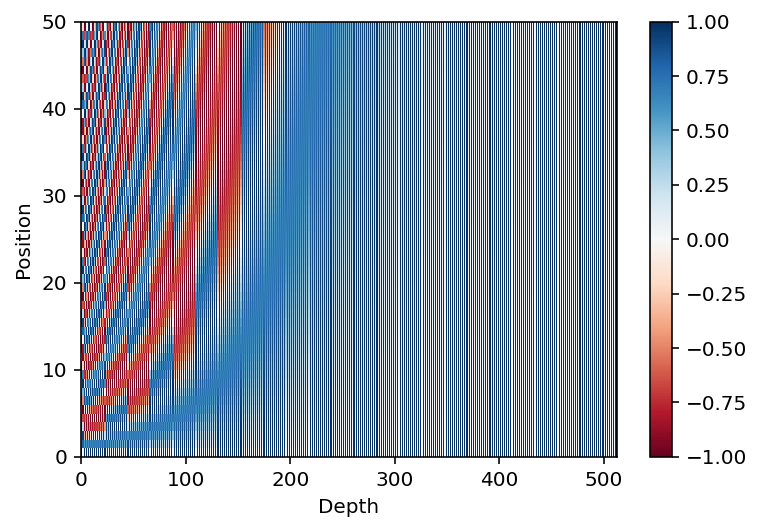

In [39]:
pos_encoding = positional_encoding(50, 512)
print(pos_encoding.shape)

plt.pcolormesh(pos_encoding[0], cmap='RdBu')
plt.xlabel('Depth')
plt.xlim((0, 512))
plt.ylabel('Position')
plt.colorbar()
plt.show()

##### **DotProduct Attention**

In [40]:
def dotproduct_attention(Q, K, V, mask=None, Er=None):
    """
    Questa funzione prende in input un "tensore di matrici", ovvero un tensore di
    cui mi interessano solo le ultime due dimensioni.

    Sono presenti i seguenti vincoli:
    Q, K, V devono avere dimensioni iniziali uguali, affinché si possa fare il matmul.

    K e V devono avere numero di righe (penultima dimensione) uguali.

    La maschera se presente deve avere dimensioni iniziali di cui si può fare
    broadcast a quelle degli altri addendi.

    In generale avremo
    Q: (..., Lq, d)
    K: (..., L, dk)
    V: (..., L, dk)
    mask: (..., seq_len_q, seq_len_k) o broadcastable

    Restituisce un tensore (..., Lq, dk) cioé il risultato delle query
    e i pesi per ogni query attention_weights
    """
    tf.assert_equal(tf.shape(Q)[-1], tf.shape(K)[-1], message="Cannot perform attention Q,K shapes")
    d = tf.shape(Q)[-1]

    QK = tf.matmul(Q,K, transpose_b=True)           # (..., Lq, L)
    if Er is not None:    # Implementazione memory efficient by Huang et al.in "Music Transformer"
        QEr = tf.matmul(Q,Er,transpose_b=True)
        QErshape= tf.shape(QEr)
        batch = QErshape[0]
        h = QErshape[1]
        Lq = QErshape[2]
        L = QErshape[3]
        zz = tf.zeros((batch, h, Lq, 1),dtype=QEr.dtype)
        QEr_pad = tf.concat( (zz,  QEr), axis=-1 )
        QEr_rsp = tf.reshape(QEr_pad, (-1, h, Lq+1, L))
        Srel = tf.slice(QEr_rsp, (0,0,1,0), (batch,h,Lq,L))
        scaled = (QK+Srel)/ tf.math.sqrt(tf.cast(d, QK.dtype)) # (..., Lq, L)
    else:
        scaled = QK/ tf.math.sqrt(tf.cast(d, QK.dtype)) # (..., Lq, L)

    if mask is not None: # La maschera seleziona gli elementi da eliminare
        tf.assert_equal(tf.shape(QK)[-1], tf.shape(mask)[-1], message="Cannot perform attention: QK' mask shapes")
        scaled += scaled*mask + (-1e10)*(1-mask) # setto ad un valore circa -infinito

    # Per ogni query ho il valore di probab di match per ogni elemento della sequenza
    matching_weights = tf.nn.softmax(scaled)        # (..., Lq, L)

    output = tf.matmul(matching_weights, V)         # (..., Lq, d_v)
    return (output, matching_weights)

##### **Multi-Head Attention**

In [41]:
class MultiHeadAttention(tf.keras.layers.Layer):
    """
    Implementazione di un MultiheadAttention Layer.

    Composto da num_heads meccanismi di Attention in parallelo.

    Ciascun Attention Head si ricava da solo le proprie Q, K e V usando
    una proiezione affine (rete neurale feedforward senza attivazione), a partire
    dalle sequenze di ingresso Q K V fornite.

    Ogni Attention head poi restituisce una parte di matrice di risultati per ogni
    query di Q.

    Ogni parte viene poi unita in una unica matrice (Lq, d_v) e passata in una
    trasformazione affine.

    """

    def __init__(self, num_heads, d_v, d, pos_max=None):
        super(MultiHeadAttention, self).__init__()
        self.num_heads = num_heads
        self.L_max = pos_max

        self.d_v = d_v
        self.d = d

        self.depth = self.d_v // self.num_heads # Parte della dimensione totale per ogni head

        assert self.d_v % self.num_heads == 0, "num_heads deve essere divisore di d_v"
        assert self.d % self.num_heads == 0, "num_heads deve essere divisore di d"

        # Trasformazioni affini
        self.wq = tf.keras.layers.Dense(self.d)
        self.wk = tf.keras.layers.Dense(self.d_v)
        self.wv = tf.keras.layers.Dense(self.d_v)

        if pos_max is not None:
              self.relative_pos = True
        else:
              self.relative_pos = False

        # Embedding per la posizione relativa tra gli elementi della sequenza
        if self.relative_pos:
              self.relative_emb = tf.keras.layers.Embedding(self.L_max, d_v)

        self.final = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(self.d_v))

    def build(self, input_shape):
        # Dovrebbe essere [ (batch_size, L, d) x 3 ]
        shapeV = input_shape[0]
        shapeK = input_shape[1]
        shapeQ = input_shape[2]

        tf.assert_equal(shapeQ[-1], shapeK[-1], message='K Q different depth')
        tf.assert_equal(shapeV[-2], shapeK[-2], message='K V different Lengths')

        return tf.concat((shapeQ[:-1],tf.fill((1,), self.d_v)), axis=0)

    def split_heads(self, x, batch_size):
        """
        Restituisce lo stesso tensore di ingresso in cui l'ultima dimensione viene divisa
        in num_heads parti grandi d_h.
        Shape di uscita (batch_size, num_heads, L, d_h)
        """
        # Suddivido l'ultima dimensione in gruppi grandi self.depth
        # ottengo shape (batch_size, L, num_heads, self.depth)
        x = tf.reshape(x, (batch_size, -1, self.num_heads, self.depth))

        # Riordino gli elementi in modo da avere num_heads come seconda dimensione
        return tf.transpose(x, perm=[0, 2, 1, 3])

    def call(self, inputs, mask=None):
        v,k,q = inputs
        batch_size = tf.shape(q)[0]

        # Ottengo nuove versioni delle matrici di input
        q = self.wq(q)  # (batch_size, Lq, d)
        k = self.wk(k)  # (batch_size, L, d)
        v = self.wv(v)  # (batch_size, L, d_v)

        q = self.split_heads(q, batch_size)  # (batch_size, num_heads, Lq, depth)
        k = self.split_heads(k, batch_size)  # (batch_size, num_heads, L, depth)
        v = self.split_heads(v, batch_size)  # (batch_size, num_heads, L, depth)

        lq = tf.shape(q)[-2]
        l = tf.shape(v)[-2]

        Er = None
        if self.relative_pos:
            rpos = tf.range(0,l) # Vettore di L posizioni relative
            rpos = tf.expand_dims(rpos,0) #(1, L)
            rpos = tf.repeat(rpos, batch_size,axis=0) # (batch_size,L)
            Er = self.relative_emb(rpos) #(batch, L, d_v)
            Er = self.split_heads(Er, batch_size)# (batch_size, num_heads, L, depth)

        # La maschera contiene 0 negli elementi da non considerare
        if mask is not None:
            mask = tf.expand_dims(mask, axis=1) # (batch_size, 1, L) booleano
            mask = tf.repeat(mask, lq, axis=1) # (batch_size, Lq, L)
            mask = tf.expand_dims(mask, axis=1) # (batch_size, 1, Lq, L) booleano
            mask = tf.cast(mask, v.dtype)

        # attention shape         => (batch_size, num_heads, Lq, depth)
        # attention_weights shape => (batch_size, num_heads, Lq, L)
        attention, attention_weights = dotproduct_attention(q, k, v, mask, Er)

        # Concateno verticalmente l'output di tutte le Attention head
        # ricordando che d_v = num_heads*depth
        attention = tf.transpose(attention, perm=[0, 2, 1, 3])  # (batch_size, Lq, num_heads, depth)
        concat_attention = tf.reshape(attention, (batch_size, lq, self.d_v))  # (batch_size, Lq, d_v)

        # Trasformazione affine finale
        return self.final(concat_attention)  # (batch_size, Lq, d_v)

##### **Transformer Layer**

In [42]:
class TransformerLayer(tf.keras.layers.Layer):
    """
    Questo Layer implementa un livello di trasformazione.

    è composto da un Multihead Attention, seguito da norm con residui,
    e da una feedforward che prende i valori di MHA prodotti, seguito da norm con
    residui.

    La rete feed forward è semplicemente un modello Sequential con due Dense layer.
    Il primo layer ha un'attivazione ReLU, il secondo è una semplice trasf affine.

    Si possono scegliere a priori il numero di Attention Heads e la dimensione del
    livello ReLU della FFNN.

    Nella rete viene eseguito un dropout (durante il training) con rate 10%.

    Il livello guarda l'intera sequenza di ingresso e genera una sequenza di uscita
    della stessa lunghezza, ricavata utilizzando Attention multipli sulla sequenza
    di ingresso.

    """

    def __init__(self, num_heads, dim_ff, d, rate=0.1, max_length=None, k=None):
        super(TransformerLayer, self).__init__()

        self.mha = MultiHeadAttention(num_heads, d, d, max_length)
        # Per costruire completamente la rete feedforward bisogna aspettare di conoscere la dimensione
        # dei valori di Attention d_v (lazy construction)
        self.ffn = tf.keras.models.Sequential()
        self.ffn.add(tf.keras.layers.Dense(dim_ff, activation='relu'))

        self.layernorm1 = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.layernorm2 = tf.keras.layers.LayerNormalization(epsilon=1e-6)

        self.dropout1 = tf.keras.layers.Dropout(rate)
        self.dropout2 = tf.keras.layers.Dropout(rate)

        self.k = k
        if self.k is not None:
            self.ffn.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d, name='PointwiseDense_{}'.format(self.k))))
        else:
            self.ffn.add(tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(d)))

    def build(self, input_shape):
        # Questo encoder riceverà dei tensori con shape (batch_size, L, dim_embedding)
        return input_shape

    def call(self, x, training=False, mask=None):
        out = self.mha([x, x, x], mask)  # (batch_size, L, d)
        out = self.dropout1(out, training=training)
        # Si applica layernorm non solo su out ma anche sui residui x direttamente
        out1 = self.layernorm1(x + out)  # (batch_size, L, d)

        ffn_output = self.ffn(out1)  # (batch_size, L, d)
        ffn_output = self.dropout2(ffn_output, training=training)
        out2 = self.layernorm2(out1 + ffn_output)  # (batch_size, L, d)

        return out2

##### **Encoder**

In [43]:
class Encoder(tf.keras.layers.Layer):
    """
    L'encoder completo comprende diversi layers di trasformazione in parallelo.

    Inoltre gestisce anche le sequenze di input della forma (batch_size, L) i cui
    elementi sono numeri interi non-negativi (token), lo 0 è considerato padding.

    L'encoder utilizza degli embedding per trasformare la sequenza in ingresso in
    (batch_size, L, d_embedding=d), per fare ciò deve sapere a priori quanti sono i
    diversi valori di token validi che può incontrare (0 escluso dal conteggio) e
    il valore d da cui dipende lo spazio di arrivo.

    Inoltre questa implementazione si avvale di una codifica della posizione assoluta
    di ogni elemento all'interno della sequenza usando encoding sinusoidali.
    Deve perciò conoscere a priori la lunghezza massima di una sequenza L di token.

    """

    def __init__(self, d, num_layers, num_heads, dim_ff, vocab_size,
               max_pos, rate=0.1):
        super(Encoder, self).__init__()

        self.d = d
        self.num_layers = num_layers

        self.embedding = tf.keras.layers.Embedding(vocab_size+1, d, mask_zero=True)

        # Fornisce per ogni posizione nella sequenza un embedding che la rappresenta
        self.pos_encoding = positional_encoding(max_pos, d) # (1, max_pos, d)

        self.enc_layers = [TransformerLayer(num_heads, dim_ff, d, rate, max_pos, i) for i in range(num_layers)]

        self.dropout = tf.keras.layers.Dropout(rate)
        self.normal = tf.keras.layers.LayerNormalization(epsilon=1e-6)

    def build(self, input_shape):
        return (input_shape[0], input_shape[-1])

    def compute_mask(self, x, mask=None):
        return self.embedding.compute_mask(x)

    def call(self, x, training=False):
        L = tf.shape(x)[1]

        # Adding 2 embedding of position and content
        x = self.embedding(x)                                 # (batch_size, L, d)
        mask = x._keras_mask
        x *= tf.math.sqrt(tf.cast(self.d, tf.float32))
        x += self.pos_encoding[:, :L, :]

        x = self.dropout(x, training=training)

        for i in range(self.num_layers):
            x = self.enc_layers[i](x, training, mask)

        # L'encoding finale sarà la media degli encoding di ogni elemento della seq.
        # Elimino la dipendenza dalla posizione nella sequenza.
        # Qui introduco un effetto "collo di bottiglia", in modo da rendere il più
        # possibile compressa l'informazione ed evitare che trapelino troppe informazioni
        # dirette al decoder. (l'encoder potrebbe altrimenti "suggerire" gli output corretti)
        x = tf.reduce_mean(x, axis=1)         # (batch_size, d)

        return self.normal(x)

##### **Decoder**

In [44]:
class Decoder(tf.keras.layers.Layer):
    def __init__(self, d, num_layers, num_heads, dim_ff, max_pos, rate=0.1):
        super(Decoder, self).__init__()

        self.d = d
        self.num_layers = num_layers

        self.dec_layers = [TransformerLayer(num_heads, dim_ff, d, rate, max_pos, k=i) for i in range(num_layers)]
        self.dropout = tf.keras.layers.Dropout(rate)

    def build(self, input_shape):
        return input_shape

    def call(self, encodings, training=False, mask=None):
        encodings = self.dropout(encodings, training=training)
        for i in range(self.num_layers):
            x = self.dec_layers[i](encodings, training=training, mask=mask)
        # x => (batch_size, L, d)
        return x

In [45]:
sample_decoder = Decoder(num_layers=2, d=512, num_heads=8, 
                         dim_ff=2048, max_pos=200)
temp_input = tf.random.uniform((64, 80, 512), dtype=tf.float32, minval=0, maxval=200)

sample_decoder_output = sample_decoder(temp_input, training=False, mask=None)

print(sample_decoder_output.shape)

(64, 80, 512)


##### **Transformer AutoEncoder**

In [46]:
class TransformerAE(tf.keras.Model):
    def __init__(self, num_layers, d, num_heads, dim_ff, vocab_size, 
               max_pos, rate=0.1):
        super(TransformerAE, self).__init__()

        self.vocab_size = vocab_size
        self.encoder = Encoder(d,num_layers,num_heads,dim_ff,vocab_size,max_pos,rate)
        self.decoder = Decoder(d,num_layers,num_heads,dim_ff,max_pos,rate)

        self.loss_metric = tf.keras.metrics.Mean(name='train_loss')
        self.accuracy_metric = tf.keras.metrics.Mean(name='train_accuracy')
        self.loss_measure = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')

        # La rete complessiva restituisce un output calcolato sulla base del decoder
        # L'output è una distribuzione discreta di probabilità per ciascun token valido
        # del vocabolario.
        self.final_layer = tf.keras.layers.Dense(vocab_size, activation='softmax')

#    def build(self, input_shape):
#        return (input_shape[0], input_shape[1], self.vocab_size)

    def call(self, x, training=False):
        encoding = self.encoder(x, training) # (batch_size, d)

        batch_size = tf.shape(x)[0]
        L = tf.shape(x)[1]

        encodings = tf.repeat(encoding, L, axis=0)
        encodings = tf.reshape(encodings,(batch_size, L, -1))
        mask = self.encoder.compute_mask(x)

        out = self.decoder(encodings, training=training, mask=mask)

        return self.final_layer(out)    # (batch_size, L, vocab_size)

    def loss_function(self, x, y_hat):
        mask = tf.math.logical_not(tf.math.equal(x, 0))
        # Devo far sì che i token validi partano da 0, perché l'output della rete decoder
        # ha come token minimo 0 ottenuto tramite argmax sul vettore softmax restituito
        # no, no, p
        x = tf.maximum(x-1, tf.zeros_like(x))
        loss = self.loss_measure(x, y_hat)

        mask = tf.cast(mask, dtype=loss.dtype)
        loss *= mask # Seleziono quei contributi di loss che corrispondono a token validi

        return tf.reduce_sum(loss)/tf.reduce_sum(mask)
  
    def accuracy_function(self, x, y_hat):
        y_hat = tf.argmax(y_hat, axis=-1)+1 # converto a token interi y_hat(il token 0 no)
        accuracies = tf.equal(x, tf.cast(y_hat,x.dtype))

        mask = tf.math.logical_not(tf.math.equal(x, 0))
        accuracies = tf.math.logical_and(mask, accuracies)

        accuracies = tf.cast(accuracies, dtype=tf.float32)
        mask = tf.cast(mask, dtype=tf.float32)
        # numero medio di token non nulli azzeccati
        return tf.reduce_sum(accuracies)/tf.reduce_sum(mask)

    @tf.function()
    def train_step(self, data):
        x = data # Durante il training ho bisogno solo di un batch di sequenze
        N = tf.shape(x)[0]
        L = tf.shape(x)[1]

        with tf.GradientTape() as tape:
            y_hat = self(x, training=True)
            loss = self.loss_function(x, y_hat)

        gradients = tape.gradient(loss, self.trainable_variables)
        gradients = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(self.trainable_variables, gradients)]
        self.optimizer.apply_gradients(zip(gradients, self.trainable_variables))

        self.loss_metric(loss)
        self.accuracy_metric(self.accuracy_function(x, y_hat))
        return {}
    
    @tf.function()
    def evaluation_step(self, data):
        y_hat = self(data)
        return self.loss_function(data,y_hat), self.accuracy_function(data, y_hat)
    
    def train(self, x, epochs, batch_size, validation=None, shuffle=False, prev_history=None):
        batch_size = min(x.shape[0], batch_size)
        batches = x.shape[0]//batch_size
        
        history = []
        if prev_history is not None:
            history += prev_history
            
        if validation is not None:
            history.append(
                {'training_loss': [],
                 'training_accuracy': [],
                 'validation_loss': [],
                 'validation_accuracy': []}
            ) # new training session
        else:
            history.append(
                {'training_loss': [],
                 'training_accuracy': []}
            ) # new training session
        
        for epoch in range(epochs):
            self.loss_metric.reset_states()
            self.accuracy_metric.reset_states()

            if shuffle:
                np.random.shuffle(x)

            for i in range(0,x.shape[0],batch_size):
                batch = x[i:i+batch_size]
                self.train_step(batch)

                print('\rBatch {}/{} loss: {:.4f} accuracy: {:.4f}'.format(i//batch_size+1,
                                                                    batches,
                                                                    self.loss_metric.result(),
                                                                    self.accuracy_metric.result()),
                        end='',
                        flush=True)
            history[-1]['training_loss'].append(self.loss_metric.result())
            history[-1]['training_accuracy'].append(self.accuracy_metric.result())
            if validation is not None:
                val_loss, val_acc = self.evaluation_step(validation)
                history[-1]['validation_loss'].append(val_loss)
                history[-1]['validation_accuracy'].append(val_acc)
                print('\rEpoch {}/{} train loss: {:.4f} accuracy: {:.4f}; validation loss: {:.4f} accuracy: {:.4f}'.format(
                        epoch+1, epochs,
                        self.loss_metric.result(),
                        self.accuracy_metric.result(),
                        val_loss,val_acc))
            else:
                print('\rEpoch {}/{} loss: {:.4f} accuracy: {:.4f}'.format(epoch+1, epochs, self.loss_metric.result(), self.accuracy_metric.result()))
        return history

    def test(self, x, batch_size):
        batch_size = min(x.shape[0], batch_size)
        batches = x.shape[0]//batch_size

        cumul_acc = 0
        cumul_loss = 0
        counter = 0
        for i in range(0,x.shape[0],batch_size):
            batch = x[i:i+batch_size]
            loss, acc = self.evaluation_step(batch)
            cumul_loss += loss
            cumul_acc += acc
            counter += 1
        
        return cumul_loss/counter, cumul_acc/counter
    

#### Unconditional GRU-GAN

##### Generator

In [47]:
class GRUGenerator(tf.keras.layers.Layer):
    """
    Questo generator prende in input un vettore di dimensione latent_dimension di rumore.
    Restituisce una sequenza lunga L di note sottoforma di distribuzioni di probabilità discrete sul
    vocabolario delle note.
    
    Possono essere configurati il numero di layer di GRU e il numero di unità per livello (uguale per ogni livello).
    """
    def __init__(self, vocab_size, depth, height):
        super(GRUGenerator, self).__init__()

        assert depth > 0 and height > 0

        self.grus = [tf.keras.layers.GRU(height, return_sequences=True) for i in range(depth)]
        
        self.final = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(vocab_size, activation='softmax'))
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.vocab_size = vocab_size
  
    def build(self, input_shape):
        return (input_shape[0], input_shape[1], self.vocab_size)

    def call(self, x):
        out = x
        for gru in self.grus:
            out = gru(out)
        out = self.layernorm(out)
        return self.final(out)


In [48]:
tmp_gen = GRUGenerator(vocab_size,2,512)
tmp_rnd = tf.random.normal((256, 128))
tmp_rnd = tf.repeat(tmp_rnd, 20, axis=0)
tmp_rnd = tf.reshape(tmp_rnd, (256, 20, 128))
tmp_gen(tmp_rnd).shape

TensorShape([256, 20, 92])

##### Discriminator

In [49]:
class GRUDiscriminator(tf.keras.Model):
    """
    Questo livello riceve una sequenza di note sottoforma di interi (token) e restituisce un singolo
    valore di probabilità: p > 0.5 => la sequenza è scritta da Bach, p < 0.5 => la sequenza è falsa
    
    L'obiettivo sarà poi quello di avvicinarsi quanto più possibile al valore p=0.5
    """
    def __init__(self, vocab_size, d, fc,depth, height, bidirectional=False):
        super(GRUDiscriminator, self).__init__()

        assert depth > 0 and height > 0

        self.emb = tf.keras.layers.Embedding(vocab_size+1, d, mask_zero=True)
        
        if not bidirectional:
            self.grus = [tf.keras.layers.GRU(height, return_sequences=True) for i in range(depth-1)]
        else:
            self.grus = [tf.keras.layers.Bidirectional(tf.keras.layers.GRU(height, return_sequences=True)) for i in range(depth-1)]
        self.grus.append(tf.keras.layers.GRU(height))
        
        self.final = tf.keras.Sequential()
        self.final.add(tf.keras.layers.Dense(fc))
        self.final.add(tf.keras.layers.Dense(1, activation='sigmoid'))
        self.layernorm = tf.keras.layers.LayerNormalization(epsilon=1e-6)
        self.vocab_size = vocab_size
  
    def build(self, input_shape):
        return (input_shape[0],)

    def call(self, x):
        out = self.emb(x) # (batch, L, d)
        for gru in self.grus:
            out = gru(out)
        # ( batch, height)
        out = self.layernorm(out) # (batch, height)
        return tf.squeeze(self.final(out)) # (batch,) => 1 prediction for each sample


In [50]:
tmp_discr = GRUDiscriminator(vocab_size, 8, 512, 2, 512)
tmp_discr(x[:2])

<tf.Tensor: shape=(2,), dtype=float32, numpy=array([0.7940051 , 0.62531585], dtype=float32)>

##### GRU-GAN

In [51]:
class GRUGAN(tf.keras.Model):
    def __init__(self, latent_dimension, vocab_size, d, fc, depth, height, bidirectional=False):
        super(GRUGAN, self).__init__()

        self.vocab_size = vocab_size
        self.latent_dimension = latent_dimension
        
        self.generator = GRUGenerator(vocab_size, depth, height)
        self.discriminator = GRUDiscriminator(vocab_size, d, fc,depth, height, bidirectional)

        self.loss_measure = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none')
        
        self.gen_loss_metric = tf.keras.metrics.Mean(name='train gen loss')
        self.discr_acc_metric = tf.keras.metrics.Mean(name='train discr acc')
        self.discr_loss_metric = tf.keras.metrics.Mean(name='train discr loss')
        self.true_p_metric = tf.keras.metrics.Mean(name='train true prob')
        self.fake_p_metric = tf.keras.metrics.Mean(name='train fake prob')

    def call(self, x, return_sequence=False):
        N = tf.shape(x)[0]
        L = tf.shape(x)[1]
        
        noise = tf.random.normal((N, self.latent_dimension))
        noise = tf.repeat(noise, L, axis=0)
        noise = tf.reshape(noise, (N, L, -1))
        
        gen_out = self.generator(noise) # (N, L, vocab_size)
        fake_seq = tf.argmax(gen_out, axis=-1) + 1 # (N, L)
        
        fake_p = self.discriminator(fake_seq) # (N,)
        true_p = self.discriminator(x) # (N,)
        
        if return_sequence:
            return fake_p, true_p, gen_out
        else:
            return fake_p, true_p

    def loss_function(self, fake_p, true_p):
        # (N, )
        val1 = tf.clip_by_value(fake_p, 1e-10, 1e10)
        gen_loss = tf.reduce_mean(-tf.math.log(val1)) # il generatore massimizza l'errore del discr
        val21 = tf.clip_by_value(tf.ones_like(fake_p)-fake_p, 1e-10, 1e10)
        val22 = tf.clip_by_value(true_p, 1e-10, 1e10)
        discr_loss = tf.reduce_mean(-tf.math.log(val21) - tf.math.log(true_p)) # il discriminatore minimizza il proprio errore su entrambi
        return gen_loss, discr_loss

    def accuracy_function(self, fake_p, true_p):
        good = tf.reduce_sum(tf.cast(tf.math.greater(true_p, 0.5), dtype=tf.float32))
        good += tf.reduce_sum(tf.cast(tf.math.less(fake_p, 0.5),dtype=tf.float32))
        return good/tf.cast(2*tf.shape(fake_p)[0], dtype=tf.float32)
    
    @tf.function()
    def train_step(self, data, train_discr=True):
        x = data # Durante il training ho bisogno solo di un batch di sequenze

        with tf.GradientTape() as gen_tape, tf.GradientTape() as discr_tape:
            fake_p, true_p = self(x)
            gen_loss, discr_loss = self.loss_function(fake_p, true_p)

        gen_gradients = gen_tape.gradient(gen_loss, self.generator.trainable_variables)
        gen_gradients = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(self.generator.trainable_variables, gen_gradients)]
        
        discr_gradients = discr_tape.gradient(discr_loss, self.discriminator.trainable_variables)
        discr_gradients = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(self.discriminator.trainable_variables, discr_gradients)]
        
        if train_discr is None:
            self.discr_optimizer.apply_gradients(zip(discr_gradients, self.discriminator.trainable_variables))
            self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        elif train_discr:
            self.discr_optimizer.apply_gradients(zip(discr_gradients, self.discriminator.trainable_variables))
        elif not train_discr:
            self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))

        acc = self.accuracy_function(fake_p, true_p)
        self.gen_loss_metric(gen_loss)
        self.discr_loss_metric(discr_loss)
        self.discr_acc_metric(acc)
        self.true_p_metric(true_p)
        self.fake_p_metric(fake_p)
    
    @tf.function()
    def gen_pretrain_step(self, x):
        
        with tf.GradientTape() as tape:
            _, __, fake_seq = self(x, True)
            mask = tf.cast( tf.math.logical_not(tf.math.equal(x, 0)), dtype=fake_seq.dtype)
            gen_loss = tf.reduce_sum(tf.clip_by_value(self.loss_measure(x,fake_seq),1e-9,1e10))*mask
        
        gen_gradients = tape.gradient(gen_loss, self.generator.trainable_variables)
        gen_gradients = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(self.generator.trainable_variables, gen_gradients)]
        
        self.gen_optimizer.apply_gradients(zip(gen_gradients, self.generator.trainable_variables))
        
        self.gen_loss_metric(gen_loss)
    
    @tf.function()
    def discr_pretrain_step(self, x):
        
        with tf.GradientTape() as tape:
            fake_p, true_p = self(x)
            _, discr_loss = self.loss_function(fake_p, true_p)
        
        discr_gradients = tape.gradient(discr_loss, self.discriminator.trainable_variables)
        discr_gradients = [grad if grad is not None else tf.zeros_like(var) for var, grad in zip(self.discriminator.trainable_variables, discr_gradients)]
        
        self.discr_optimizer.apply_gradients(zip(discr_gradients, self.discriminator.trainable_variables))
        
        self.discr_loss_metric(discr_loss)
    
    def train(self, x, epochs, batch_size, g_rounds, d_rounds, shuffle=False, prev_history=None, pretraining=None):
        batch_size = min(x.shape[0], batch_size)
        batches = x.shape[0]//batch_size
        
        
        if pretraining is not None:
            # Pre-train generator
            for epoch in range(pretraining):
                self.gen_loss_metric.reset_states()
                for i in range(0,x.shape[0],batch_size):
                    batch = x[i:i+batch_size]
                    self.gen_pretrain_step(batch)

                    print('\rGen Pretraining Batch {}/{} gen loss: {:.4f}'.format(i//batch_size+1,
                                                                        batches,
                                                                        self.gen_loss_metric.result()),
                            end='',
                            flush=True)

                print('\rGen Pretraining Epoch {}/{} gen loss: {:.4f}'.format(epoch+1, pretraining,
                                                                               self.gen_loss_metric.result()))
            # Pre-train discriminator
            for epoch in range(pretraining):
                self.discr_loss_metric.reset_states()
                for i in range(0,x.shape[0],batch_size):
                    batch = x[i:i+batch_size]
                    self.discr_pretrain_step(batch)

                    print('\rDiscr Pretraining Batch {}/{} discr loss: {:.4f}'.format(i//batch_size+1,
                                                                        batches,
                                                                        self.discr_loss_metric.result()),
                            end='',
                            flush=True)

                print('\rDiscr Pretraining Epoch {}/{} discr loss: {:.4f}'.format(epoch+1, pretraining,
                                                                               self.discr_loss_metric.result()))
        
        history = []
        if prev_history is not None:
            history += prev_history
            
        history.append(
            {'gen_loss': [],
             'discr_loss': [],
             'true_p': [],
             'fake_p': []}
        ) # new training session
        
        gen_counter = 0
        discr_counter = 0
        train_discr = False
        for epoch in range(epochs):
            self.gen_loss_metric.reset_states()
            self.discr_loss_metric.reset_states()
            self.discr_acc_metric.reset_states()
            self.true_p_metric.reset_states()
            self.fake_p_metric.reset_states()

            if shuffle:
                np.random.shuffle(x)

            if not train_discr and gen_counter == g_rounds:
                train_discr = True
                gen_counter = 0
                discr_counter = 0
            
            if train_discr and discr_counter == d_rounds:
                train_discr = False
                discr_counter = 0
                gen_counter = 0
                
            for i in range(0,x.shape[0],batch_size):
                batch = x[i:i+batch_size]
                discr_cond = train_discr and (self.discr_acc_metric.result()<0.8)
                self.train_step(batch, train_discr=discr_cond)

                print('\rBatch {}/{} gen loss: {:.4f} discr loss: {:.4f} discr acc: {:.4f} true p: {:.4f} fake p: {:.4f}'.format(i//batch_size+1,
                                                                    batches,
                                                                    self.gen_loss_metric.result(),
                                                                    self.discr_loss_metric.result(),
                                                                    self.discr_acc_metric.result(),
                                                                    self.true_p_metric.result(),
                                                                    self.fake_p_metric.result()),
                        end='',
                        flush=True)
                
            history[-1]['gen_loss'].append(self.gen_loss_metric.result())
            history[-1]['discr_loss'].append(self.discr_loss_metric.result())
            history[-1]['true_p'].append(self.true_p_metric.result())
            history[-1]['fake_p'].append(self.fake_p_metric.result())
            
            print('\rEpoch {}/{} gen loss: {:.4f} discr loss: {:.4f} discr acc: {:.4f} true p: {:.4f} fake p: {:.4f}'.format(epoch+1, epochs,
                                                                           self.gen_loss_metric.result(),
                                                                           self.discr_loss_metric.result(),
                                                                           self.discr_acc_metric.result(),
                                                                           self.true_p_metric.result(),
                                                                           self.fake_p_metric.result()))
            
            if train_discr:
                discr_counter += 1
            else:
                gen_counter += 1
            
        return history


In [52]:
# latent_dimension, vocab_size, d, fc, depth, height
tmp_grugan = GRUGAN(10, vocab_size, 8, 512, 2, 512)
tmp_grugan.compute_output_shape(x[:2].shape)
tmp_fakep, tmp_truep = tmp_grugan(x[:2])
tmp_grugan.loss_function(tmp_fakep, tmp_truep)

(<tf.Tensor: shape=(), dtype=float32, numpy=1.5094216>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9779123>)

### Training

#### Scheduling del learning rate e optimizer personalizzati

In [53]:
class CustomSchedule(tf.keras.optimizers.schedules.LearningRateSchedule):
    def __init__(self, d_model, warmup_steps=4000):
        super(CustomSchedule, self).__init__()

        self.d_model = d_model
        self.d_model = tf.cast(self.d_model, tf.float32)

        self.warmup_steps = warmup_steps

    def __call__(self, step):
        arg1 = tf.math.rsqrt(step)
        arg2 = step * (self.warmup_steps ** -1.5)

        return tf.math.rsqrt(self.d_model) * tf.math.minimum(arg1, arg2)

Text(0.5, 0, 'Train Step')

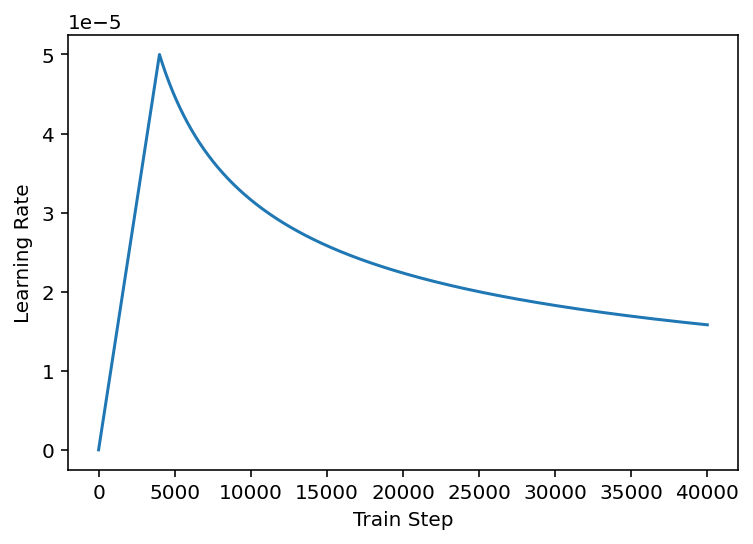

In [54]:
temp_learning_rate_schedule = CustomSchedule(1e5)

plt.plot(temp_learning_rate_schedule(tf.range(40000, dtype=tf.float32)))
plt.ylabel("Learning Rate")
plt.xlabel("Train Step")

#### Training

In [55]:
autoenc=GRUVAutoencoder(vocab_size, 8, 64, 512, 2, 512, 2)#TransformerAE(20,128,8,2048,vocab_size,L)#GRUVAutoencoder(vocab_size, 128, 128, 512, 2, 512, 2)#Transformer(5,512,8,512,vocab_size,256) #
autoenc.compute_output_shape(x[:1].shape)

TensorShape([1, 20, 92])

In [56]:
learning_rate = CustomSchedule(1e3)
optimizer = tf.keras.optimizers.Adam(1e-5, beta_1=0.9, beta_2=0.98, epsilon=1e-9)

In [57]:
autoenc.optimizer = optimizer

In [ ]:
autoenc.load_weights(join(base_path, 'Experiments/Experiment21/Weights'))

In [ ]:
history = load_obj(join(base_path, 'Experiments/Experiment21/history.pkl'))

history = autoenc.train(x, batch_size=256, epochs=100, validation=x_valid, prev_history=history)

In [ ]:
save_obj(history, join(base_path, join('Experiments/Experiment21', 'history.pkl')))

In [ ]:
autoenc.save_weights(join(base_path, 'Experiments/Experiment21/Weights'))

### Testing

In [58]:
autoenc=GRUVAutoencoder(vocab_size, 8, 128, 512, 2, 512, 2)
autoenc.load_weights(join(base_path, 'Experiments/Experiment13/Weights'))

In [59]:
autoenc.test(x_test, 256)

(<tf.Tensor: shape=(), dtype=float32, numpy=0.7012589>,
 <tf.Tensor: shape=(), dtype=float32, numpy=0.9469237>)

### Visualizza training di un esperimento

In [60]:
experiment_number = 13
history = load_obj(join(base_path, 'Experiments/Experiment{}/history.pkl'.format(experiment_number)))

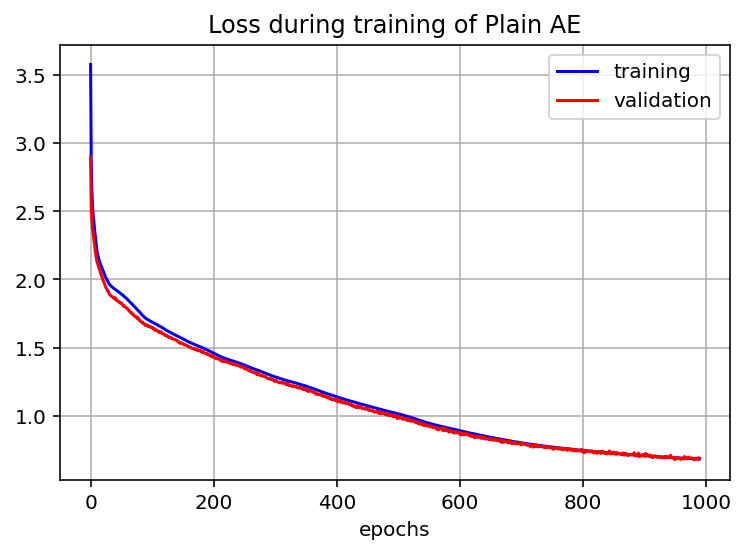

In [61]:
hh = merge_history(history)
plt.plot(np.arange(len(hh['training_loss'])), [ten.numpy() for ten in hh['training_loss']], '-b',
         np.arange(len(hh['validation_loss'])), [ten.numpy() for ten in hh['validation_loss']], '-r')
plt.grid(True)
plt.xlabel('epochs')
plt.title('Loss during training of Plain AE')
plt.legend(['training', 'validation'])
plt.show()

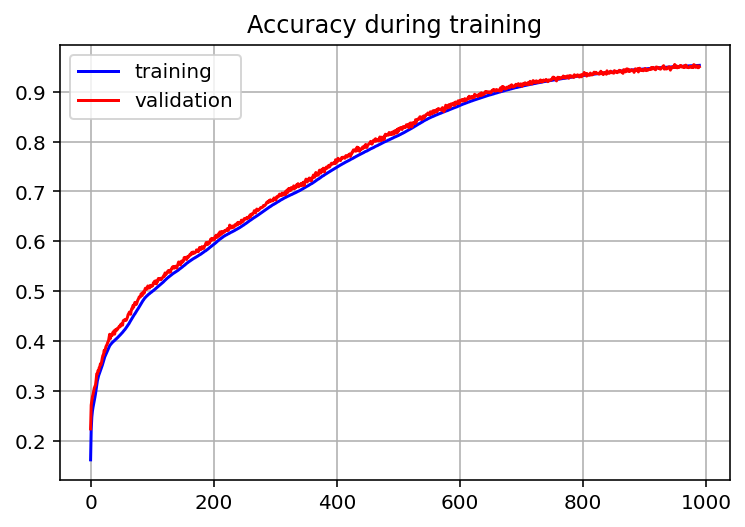

In [62]:
hh = merge_history(history)
plt.plot(np.arange(len(hh['training_accuracy'])), [ten.numpy() for ten in hh['training_accuracy']], '-b',
         np.arange(len(hh['validation_accuracy'])), [ten.numpy() for ten in hh['validation_accuracy']], '-r')
plt.grid(True)
plt.title('Accuracy during training')
plt.legend(['training','validation'])
plt.show()

### Generazione contenuto

In [63]:
model=GRUVAutoencoder(vocab_size, 8, 128, 512, 2, 512, 2)
model.load_weights(join(base_path, 'Experiments/Experiment13/Weights'))

In [64]:
def seq2stream(seq, min_token):
    """
    Input:    seq     una sequenza di token numerici, minore token valido == 1
         min_token  il valore minimo del token MIDI di uscita
    Output: un oggetto stream dalla libreria music21 che consente il plot e
          la trasformazione in file .midi
    """
    sst = m21.stream.Stream()
    tokens = np.copy(seq[np.logical_not(np.equal(seq, 0))])
    tokens += min_token-1
    for i in range(len(tokens)):
        pitch = m21.pitch.Pitch()
        pitch.midi = tokens[i]
        note = m21.note.Note()
        note.pitch = pitch
        note.duration = m21.duration.Duration()
        note.duration.quarterLength = 1
        sst.append(note)
        note.offset = i
  
    return sst

Test di generazione di un pezzo

In [65]:
z = tf.random.normal((1,128))

In [66]:
z_rep = tf.reshape( tf.repeat( z , 80,axis=0 ) , (1,80,128))

In [67]:
sample = tf.squeeze(tf.argmax(model.decoder(z_rep),axis=-1)).numpy()+1

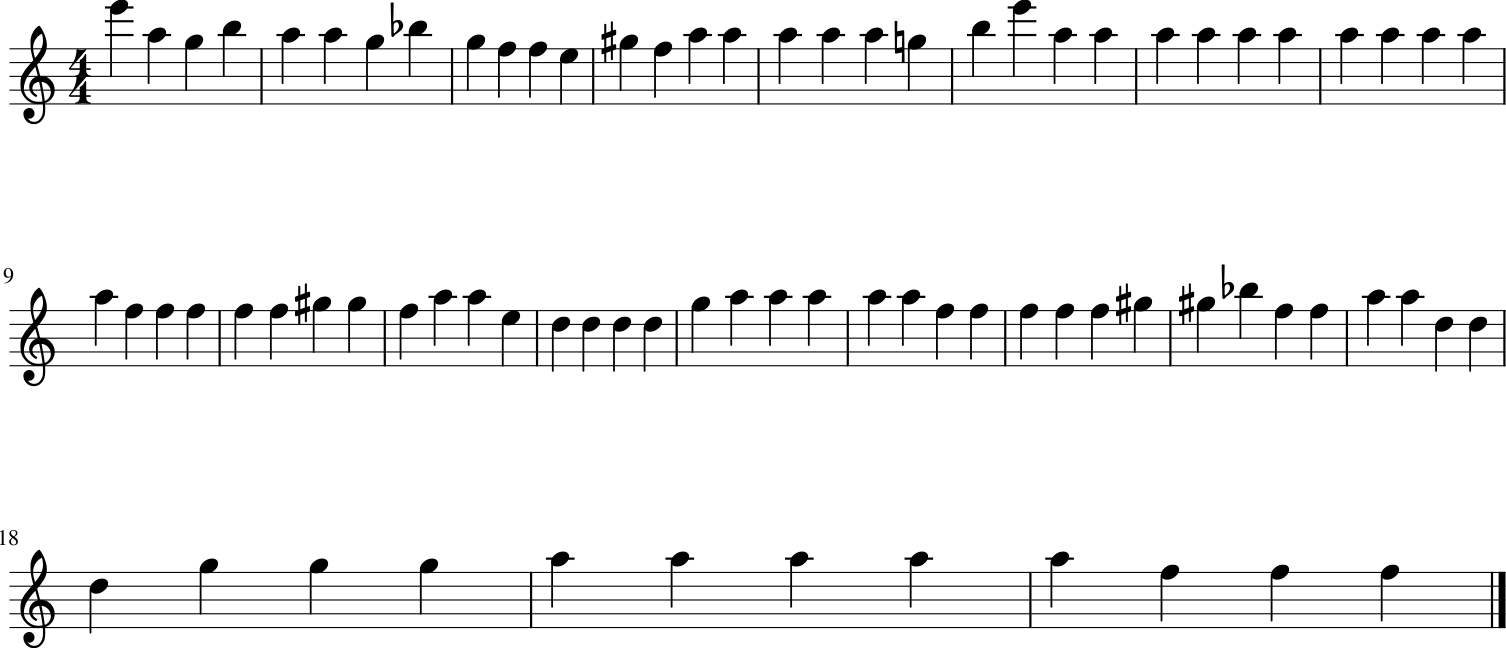

In [68]:
if colab:
    seq2stream(sample, min_token).plot()
else:
    seq2stream(sample, min_token).show()

In [69]:
if not colab:
    seq2stream(sample, min_token).show('midi')

Test di ricostruzione pezzo

In [70]:
rint = np.random.randint(x_test.shape[0])
reconstr = tf.argmax(tf.squeeze(autoenc(x_test[rint:rint+1])),axis=-1).numpy()+1

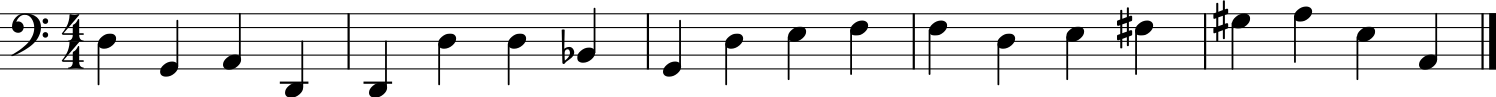

In [71]:
if colab:
    seq2stream(x_test[rint], min_token).plot()
else:
    seq2stream(x_test[rint], min_token).show()

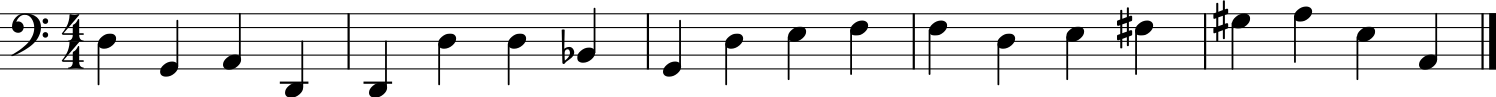

In [72]:
if colab:
    seq2stream(reconstr, min_token).plot()
else:
    seq2stream(reconstr, min_token).show()

In [73]:
if not colab:
    seq2stream(x_test[rint], min_token).show('midi')

In [74]:
if not colab:
    seq2stream(reconstr, min_token).show('midi')

Test di interpolazione progressiva tra pezzi di Bach nello spazio latente

In [75]:
rint1 = np.random.randint(len(x_test))
rint2 = np.random.randint(len(x_test))

In [76]:
z1 = model.encoder(x_test[rint1:rint1+1])
z2 = model.encoder(x_test[rint2:rint2+1])
z20 = z1*0.8+z2*0.2
z40 = z1*0.6+z2*0.4
z60 = z1*0.4+z2*0.6
z80 = z1*0.2+z2*0.8

In [77]:
out20 = tf.squeeze(tf.argmax(model.decoder(tf.reshape( tf.repeat( z20 , 20,axis=0 ) , (1,20,128))),axis=-1)).numpy()+1
out40 = tf.squeeze(tf.argmax(model.decoder(tf.reshape( tf.repeat( z40 , 20,axis=0 ) , (1,20,128))),axis=-1)).numpy()+1
out60 = tf.squeeze(tf.argmax(model.decoder(tf.reshape( tf.repeat( z60 , 20,axis=0 ) , (1,20,128))),axis=-1)).numpy()+1
out80 = tf.squeeze(tf.argmax(model.decoder(tf.reshape( tf.repeat( z80 , 20,axis=0 ) , (1,20,128))),axis=-1)).numpy()+1

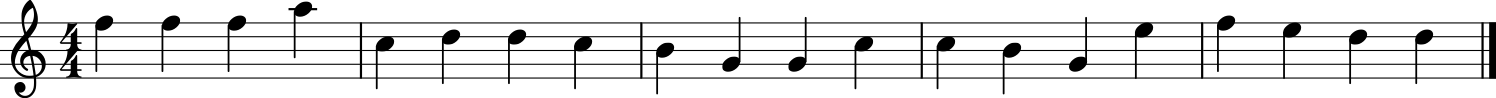

In [78]:
if colab:
    seq2stream(x_test[rint1], min_token).plot()
else:
    seq2stream(x_test[rint1], min_token).show()

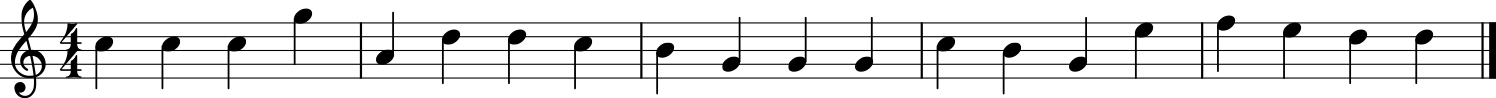

In [79]:
if colab:
    seq2stream(out20, min_token).plot()
else:
    seq2stream(out20, min_token).show()

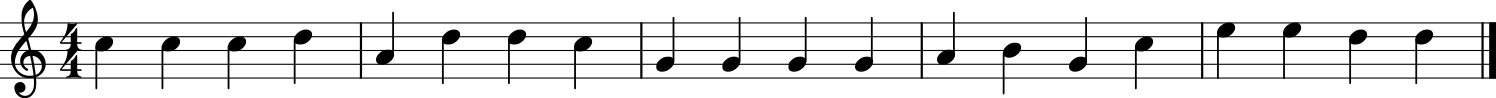

In [80]:
if colab:
    seq2stream(out40, min_token).plot()
else:
    seq2stream(out40, min_token).show()

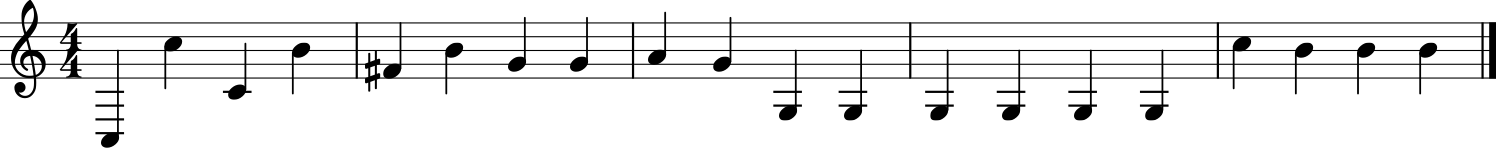

In [81]:
if colab:
    seq2stream(out60, min_token).plot()
else:
    seq2stream(out60, min_token).show()

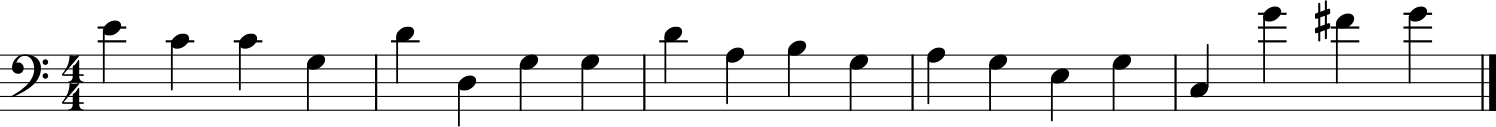

In [82]:
if colab:
    seq2stream(out80, min_token).plot()
else:
    seq2stream(out80, min_token).show()

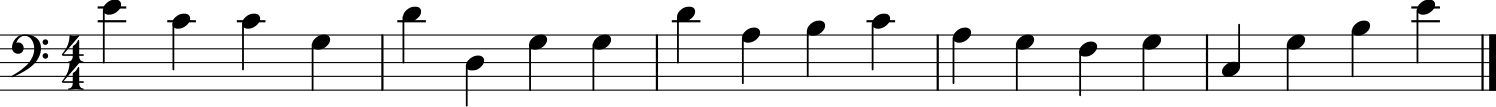

In [83]:
if colab:
    seq2stream(x_test[rint2], min_token).plot()
else:
    seq2stream(x_test[rint2], min_token).show()

### Visualizzazione dello spazio latente

è possibile sfruttare la pca per trovare i 2 o 3 assi con più varianza tra i vari encoding dei pezzi nel dataset

In [84]:
pca = PCA(n_components=2) # Per grafici 2D

In [85]:
encoded_x = model.encoder(x_test)

In [86]:
encoded2 = pca.fit_transform(encoded_x)

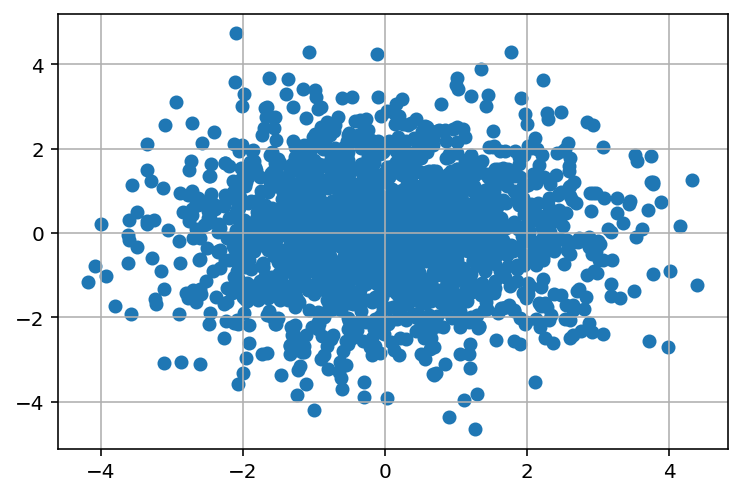

In [87]:
plt.scatter(encoded2[:,0], encoded2[:,1])
plt.grid(True)
plt.show()